In [47]:
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from vvc import config

In [98]:
dataset_folder = config.video_folder

experiment_folder = os.path.join(config.base_folder, 'Videos', 'frcnn-resnet50-transfer')

annotations_file = 'MOV_0861.mp4.json'

test_file = os.path.join(dataset_folder, annotations_file)
experiment_file = os.path.join(experiment_folder, annotations_file)

test_file

'/home/juan/workspace/Maestria/Videos/original/MOV_0861.mp4.json'

In [45]:
def vott_to_dataframe(json_file):
    test_annotations = {}

    df = pd.DataFrame()

    with open(json_file) as json_data:
        data = json.load(json_data)

        for frame_id, boxes in data['frames'].items():
            if not frame_id in test_annotations:
                test_annotations[frame_id] = {}
            for box in boxes:
                for tag in box['tags']:
                    if not tag in test_annotations[frame_id]:
                        test_annotations[frame_id][tag] = 0
                    test_annotations[frame_id][tag] += 1

    df = pd.DataFrame.from_dict(test_annotations, orient='index')
    df = df.fillna(0)
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    
    return df
    
test = vott_to_dataframe(test_file)
test.iloc[4:].head()

,car,motorbike
5,2,2.0
6,1,0.0
7,2,2.0
8,2,2.0
9,2,2.0


In [66]:
def vvc_to_df(json_file):
    summary = {}

    df = pd.DataFrame()

    with open(json_file) as json_data:
        data = json.load(json_data)
        for frame_id, objects in data['frames'].items():
            
            if not frame_id in summary:
                summary[frame_id] = {}
            
            for obj in objects['objects']:
                tag = obj['tag']
                
                if not tag in summary[frame_id]:
                    summary[frame_id][tag] = 0
                
                summary[frame_id][tag] += 1

    df = pd.DataFrame.from_dict(summary, orient='index')
    df = df.fillna(0)
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    df = df.reindex(sorted(df.columns), axis=1)
    
    df.index += 1
    
    return df
    
experiment = vvc_to_df(experiment_file)
experiment.iloc[4:].head()

,car,motorbike
5,1,2.0
6,1,1.0
7,1,1.0
8,1,1.0
9,1,1.0


In [101]:
def calc_precision(test, experiment): 
    error = test.sub(experiment, axis='columns', fill_value=0).abs().div(test, fill_value=0)

    error = error.replace([np.inf, -np.inf], 1)
    error = error.fillna(0)

    precision = 1 - error
    precision.sort_index(inplace=True, kind='mergesort')

    return precision

In [110]:
test = vott_to_dataframe(test_file)

avg_precision = pd.DataFrame(index=test.columns)

for model in config.models:
    experiment_folder = os.path.join(config.base_folder, 'Videos', model)
    experiment_file = os.path.join(experiment_folder, annotations_file)
    
    experiment = vvc_to_df(experiment_file)
    
    precision = calc_precision(test, experiment)
    
    mean_precision = precision.mean().to_frame(model)
    
    print(mean_precision)
    
    avg_precision = avg_precision.join(mean_precision)

avg_precision

             frcnn-resnet50
car                0.522989
motorbike          0.827586
person             0.724138
pottedplant        0.781609
           frcnn-resnet50-transfer
car                       0.258621
motorbike                 0.885057


,frcnn-resnet50,frcnn-resnet50-transfer
car,0.522989,0.258621
motorbike,0.827586,0.885057


<Figure size 432x288 with 0 Axes>

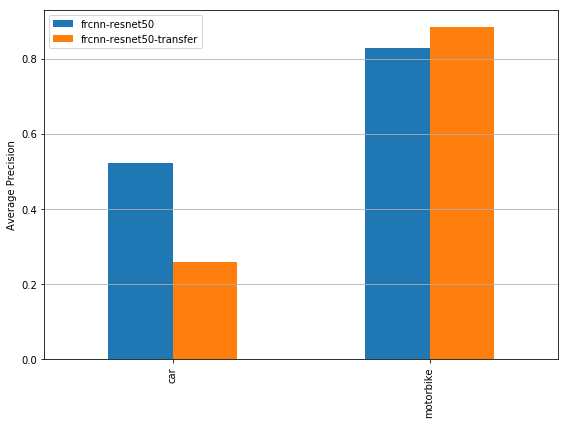

In [113]:
plt.figure()

ax = avg_precision.plot.bar(figsize=(8, 6))

plt.grid(axis='y')

ax.set_ylabel('Average Precision')

plt.tight_layout()

fig = ax.get_figure()
fig.savefig('./img/mean_precision.png')